In [4]:
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pystan
import seaborn as sns
import scipy as sp

# __Bayesian Inference on Spotify Streams__
#### Project work by __Ville Saarinen__ and __Sirong Huang__
## __Introduction__
In this project we are provided with the audio features of the top 30 most streamed Spotify songs of years 2017 and 2018, and our goal is to predict the top 30 song rankings from their audio features. 

#### __This notebook is structured in the following way:__
1. __Exploratory data analysis__
2. __Introducing bayesian linear regression model__  
    2.1 Model construction  
    2.2 Prior analysis
3. __Modeling and inference__  
    3.1 Three predictor linear model      
    3.2 Five predictor non-linear model with interaction terms  
4. __Model comparison__
5. __Conclusions__
6. __Limitations and future improvements__

## __1. Exploratory Data Analysis__
We pre-processed features by removing categorical variables, centering them on 0 and standardizing by dividing the population standard deviation. For more detailed description, see our [pre-processing notebook](). Two of the most informative plots are shown here. These are imported from more thorough exploratory data analysis notebook which that can be accessed at [our github repository](). Original EDA was made using three data sets: finnish, swedish and global. In the end we decided to concentrate only on global data.

In [5]:
geo_labels = ['Global', 'Finland', 'Sweden'] 
tri_palette = ['#669900', '#0099ff', '#ffbd00']

### __Correlation matrices__


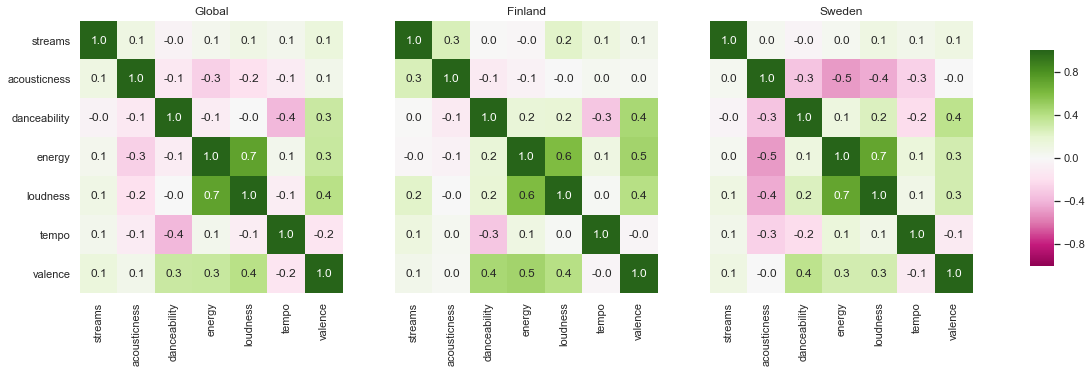

In [12]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.95, .2, .02, .6])
dfs = [global_data.corr(), finland_data.corr(), sweden_data.corr()]
sns.set(rc={'figure.figsize':(14,4)})

for i, ax in enumerate(axs.flat):
    ax.set_title(geo_labels[i])
    sns.heatmap(dfs[i], ax=ax,
                cbar=i == 0,
                vmin=-1.0, vmax=1.0,
                center=0.0,
                cmap='PiYG',
                cbar_ax=None if i else cbar_ax,
                annot=True,
                fmt='.1f')

From heatmaps we can see that none of the single predictors have a strong correlation with the number of streams. However we can identify following weak co-correlation relationships (in descending order):

__Positive co-correlation__:
* Loudness ~ Energy (0.7)
* Valence ~ Loudness (0.4)
* Valence ~ Energy (0.3)
* Valence ~ Danceability (0.3)

__Negative co-correlation__:
* Danceability ~ Tempo (-0.4)
* Acousticness ~ Energy (-0.3)
* Acousticness ~ Loudness (-0.2)
* Tempo ~ Valence (-0.2) 

### __Data comparison by geography__
We plot the overlayed pairplots for all three data sets. For this purpose we log-transform the streams which makes it easier to interpret visually.


/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/ipykernel/__main__.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



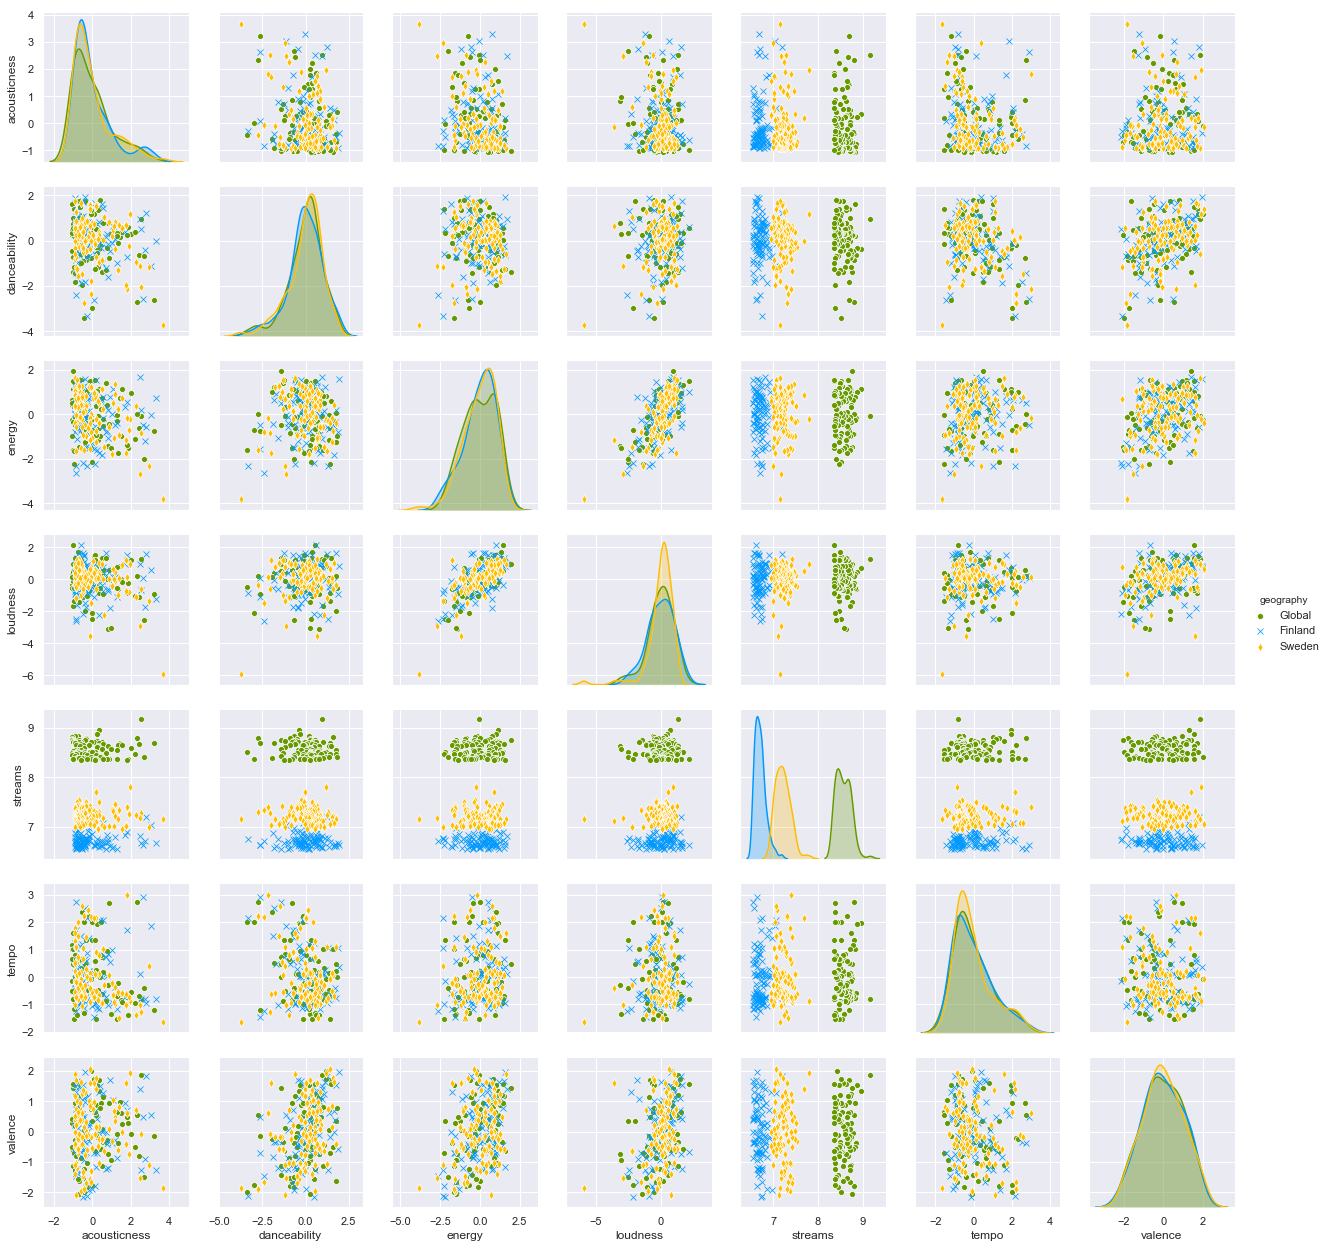

In [11]:
select = 'geography'
f1, f2, f3 = global_data, finland_data, sweden_data
f1[select], f2[select], f3[select] = geo_labels[0], geo_labels[1], geo_labels[2]
df = pd.concat([f1,f2,f3],axis=0)
df['streams'] = np.log10(df['streams'])

g = sns.pairplot(df, hue=select, diag_kind='kde', palette=tri_palette, markers=['o','x','d'])
 
for ax,col in zip(g.axes.flat, tri_palette): 
    plt.setp(ax.get_xticklabels(), rotation=45)    

 From pair distribution plots we can observe following points:
1. number of streams is long tail right skewed: most songs have less views with a few having a lot of views
2. none of the audio features appear to have really strong linear correlation with number of streams
3. energy and loudness are highly correlated, which is to be expected since [one of the determining factors of energy is loudness](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) 
4. there is some (although limited) amount of correlation between other pairs (for example `valence` and `loudness`)
5. `valence` and `energy` seem to be symmetrically distributed (normal), `energy` has two peaks (multimodal)

The exploratory data analysis suggests that the true causal mechanism determining the popularity of any given song is probably more complex than the audio features that are available. There are possibly many exogeneous factors (popularity of the artist, marketing, cultural and regional differences etc.) that are not captured by the audio features. 

We should also take into consideration the fact that audio features provided by Spotify API might not accurately capture the true musical characteristics of the songs, but rather they are algorithmically computed approximations of the qualities they are supposed to model. 

### __Imports and methods__
#### Import stan convergence utilities from local directory 
Utilities originally by Betancourt, [see this notebook on Bayesian workflow](http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html).

In [6]:
%run utility/stan_utility.py

#### Import data

In [7]:
names = ['streams', 'acousticness', 'danceability', 'energy', 'loudness', 'tempo', 'valence']
names_2018 = ['streams', 'acousticness', 'danceability', 'loudness', 'tempo', 'valence']

global_data  = pd.read_csv('./data/global_selected.csv',header=None, names=names)
global_data_2018 = pd.read_csv('./data/2018_global_selected.csv',header=None, names=names)

#### Select top 30 

In [8]:
global_data = global_data[0:30]
global_data_2018 = global_data_2018[0:30]

#### Methods for plotting predictive distributions and loo-values

In [9]:
def plot_predictive_acc(global_data, global_data_2018, samples):
    fig, [ax1, ax2] = plt.subplots(2,1,figsize=(13,9), sharex=True)

    streams17 = exp10_t(global_data['streams'])
    
    plt.suptitle('Predictive performance', y=1.02, size=16)
    plt.xlabel('Song ranking by stream count')
    plt.xlim(0.7,30.3)
    
    cols = ['blue','orange','grey']

    plt.ylim(0,max(streams17))
    plt.xticks(range(1,31),labels=['{0}'.format(i) for i in range(1,31)])
    X_top30 = range(1,len(streams17)+1)
    
    mean_ypred = np.mean(samples['ypred'], axis=0)
    sd_ypred = np.sqrt(np.var(samples['ypred'], axis=0))
    
    mean_ypred_18 = np.mean(samples['ypred_2018'], axis=0)
    sd_ypred_18 = np.sqrt(np.var(samples['ypred_2018'], axis=0))
    
    ax1.plot(X_top30, streams17, '.--', color=cols[0], alpha=.5, label='Top songs for 2017')
    ax1.errorbar(X_top30, mean_ypred, yerr=sd_ypred, fmt='o-', color='orange', label='Prediction')
    
    sns.regplot(list(X_top30), list(np.mean(samples['ypred'], axis=0)), 'o-', color=cols[2], ax=ax1, scatter=False, label='Prediction regression fit with 95%-ci')

    ax1.legend(loc='best')
    ax1.set_ylabel('Streams')

    X_top30 = range(1,len(global_data_2018['streams'])+1)
    ax2.plot(X_top30, global_data_2018['streams'], '.-', color=cols[0], alpha=.5, label='Top songs for 2018')
    ax2.errorbar(X_top30, mean_ypred_18, yerr=sd_ypred_18, fmt='o-', color='orange', label='Prediction')
    
    sns.regplot(list(X_top30), list(mean_ypred_18), 'o-', color=cols[2], ax=ax2, scatter=False, label='Prediction regression fit with 95%-ci')
    ax2.legend(loc='best')
    ax2.set_ylabel('Streams')

    plt.tight_layout()
    
def calculate_and_print_loo(fit, loos):
    prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
    azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                           observed_data='y', 
                           posterior_predictive='ypred', 
                           log_likelihood='log_lik')
    loo_m = az.loo(azfit)
    loo_m['Model'] = model_name
    loo_m['div'], loo_m['treedepth'], loo_m['energy'] = div_check, tree_check, energy_check
    loos = loos.append(loo_m, sort=True)
    
    return loo_m.set_index('Model'), loos 

## __2. Introducing Bayesian Linear Regression Model__

### __2.1 Model Construction__
#### __Motivation__ 
We are interested in finding out which features in the spotify's song data determine the number of streams in Spotify. We will study this hypothesis by using multiple regression models which model the relationship between the number of streams and audio features which we use as predictors. Models are trained using the global aggregated data queried from Spotify API for the year 2017. We will do prediction for both 2017 as a model checking procedure and for 2018 data for curiosity. The `streams` in the 2018 data set already includes data for 11 months of year 2018.   

#### __Assumptions__
We first assume that the relationship between $d$-dimension predictor variables $X = \{X_1,X_2,...,X_d\}$ each having $n$ elements, and observations $Y = \{y_1,y_2,...,y_n\}$ (streams) is modeled by *linear dependence*. We also assume that all elements $y \in Y$ and $x \in X$ are independent of each other. 

The mean $\mu$ of model is described by: $\mu = \mathbb{E}[y_i \mid \beta, X] = \alpha + \beta_1 X_1 + \beta_2 X_2 + , ... , + \beta_d X_d\;$, where $\alpha$ is the intercept and $\beta = \{\beta_1, \beta_2, ... , \beta_d\}$ the parameter vector for coefficients.

We also need to consider the unknown error term $\sigma$. Thus in general form our model is of the form:  

$$\large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_d X_d, \;\sigma)$$

In bayesian context we are not interested about point-estimate, but rather the whole posterior distribution which takes the form:

$$\large p(\beta \mid y, X) = \frac{p(y \mid \beta,X)p(\beta\mid X)}{p(y\mid X)}$$

Exploratory data analysis showed that $Y$ is right skewed, this could suggest that our model would benefit from log-transformation. Let's take a closer look at the distribution of $Y$:

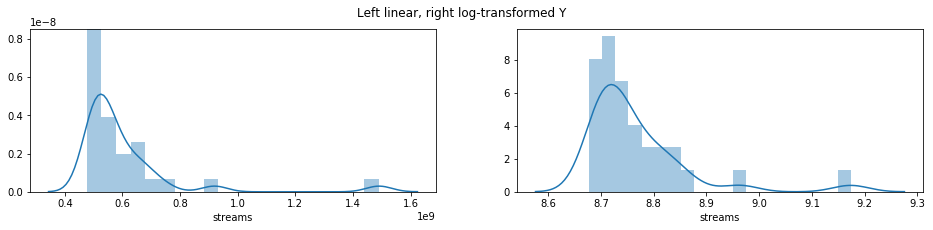

In [10]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,3))
fig.suptitle('Left linear, right log-transformed Y')
sns.distplot(global_data['streams'], ax=ax1, bins=20)
sns.distplot(np.log10(global_data['streams']), ax=ax2, bins=20)

#### Log-transformation of $Y$
Plots suggest that log-transformation evens out some of the right-skewness. Thus we will use log-transformed data for fitting the model:

In [11]:
global_data['streams'] = np.log10(global_data['streams'])

We also define functions for inverse transformation of log-data:

In [12]:
exp10 = lambda x: 10**x 
exp10_t = lambda X: np.asarray(list(map(exp10, X)))

### __2.2 Prior analysis__
Generally we know that the true determining factors of $Y$ are extremely complex and that developing rational and workable intuitions about the $\beta$-priors is a difficult task. The task gets even more difficult as the complexity of the model increases. However we can make basic hypothesis about the way in which different predictors might affect $Y$ and do limited sensitivity analysis based on that. Based on prior knowledge we could hypothesize for example that `loudness` might be a necessary (but not sufficient) component in contemporary music for achieving popularity (there has been extensive discussion about so called 'loudness wars' in the audio engineering industry, see for example [this](https://www.soundonsound.com/sound-advice/dynamic-range-loudness-war)).

In [13]:
def plot_loudness(global_data, global_data_2018, label):
    fig = plt.figure(figsize=(18,5))
    fig.suptitle(label)
    ax1 = plt.subplot2grid((2,5), (0,0), colspan=4, rowspan=2)
    ax1.set_title('Loudness by ranking')
    
    ax1.set_ylabel('Loudness')
    ax1.set_xlabel('Song Ranking')
    ax1.plot(global_data.index.values, global_data['loudness'], '.-', label='2017 songs')
    ax1.plot(global_data_2018.index.values, global_data_2018['loudness'], '.-', label='2018 songs')
    ax1.set_ylim(-4,4)
    ax1.legend()

    ax2 = plt.subplot2grid((2,5), (0,4), colspan=1, rowspan=1)
    ax2.set_title('Loudness kde')

    sns.distplot(global_data['loudness'], hist=True, kde=True, ax=ax2)
    ax2.set_xlabel('loudness')
    
    ax3 = plt.subplot2grid((2,5), (1,4), colspan=1, rowspan=1)    
    sns.distplot(global_data_2018['loudness'], color='orange', hist=True, kde=True, ax=ax3)
    ax3.set_xlabel('loudness')

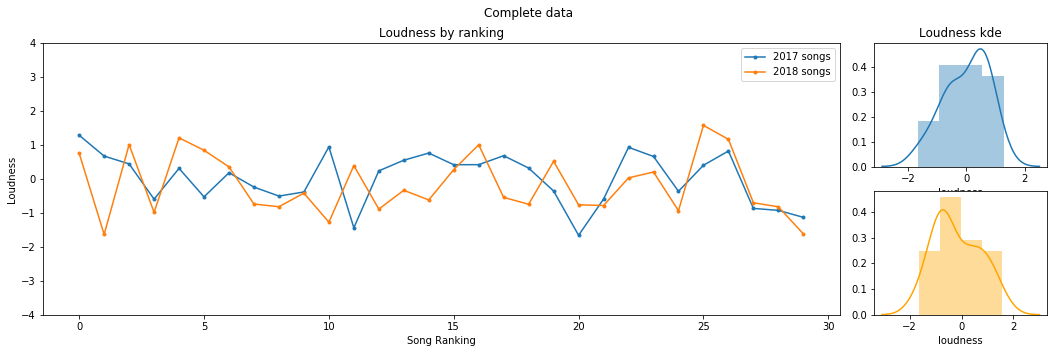

In [14]:
plot_loudness(global_data, global_data_2018, 'Complete data')

We can see quite even and symmetric distributions centered around 0 which doesn't seem to support the `loudness` hypothesis. We can explain this by noticing that there are slower songs and ballads also in the mix. Thus by further hypothesizing that songs with high `acousticness` and low `danceability` scores are less loud than for example electronic music that is usually highly compressed and thus easier to make loud. If we remove songs that are highly acoustic and non-danceable, we get:

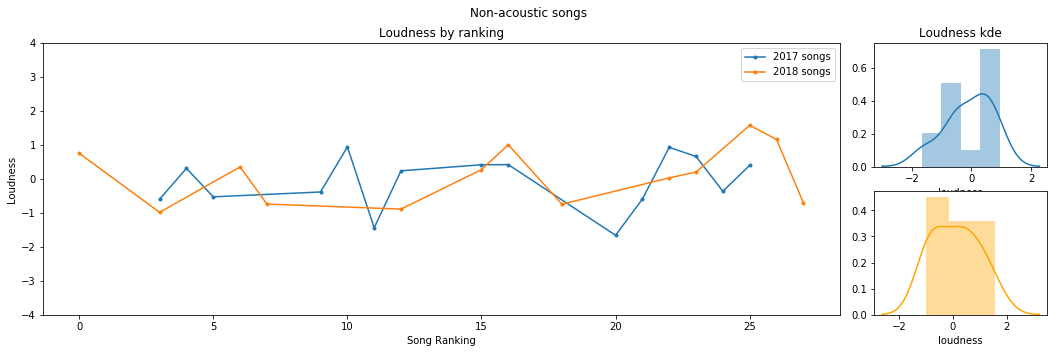

In [15]:
glob_non_ac = global_data[global_data['acousticness'] < -.5]
glob_non_ac_2018 = global_data_2018[global_data_2018['acousticness'] < -.5]
plot_loudness(glob_non_ac, glob_non_ac_2018, 'Non-acoustic songs')

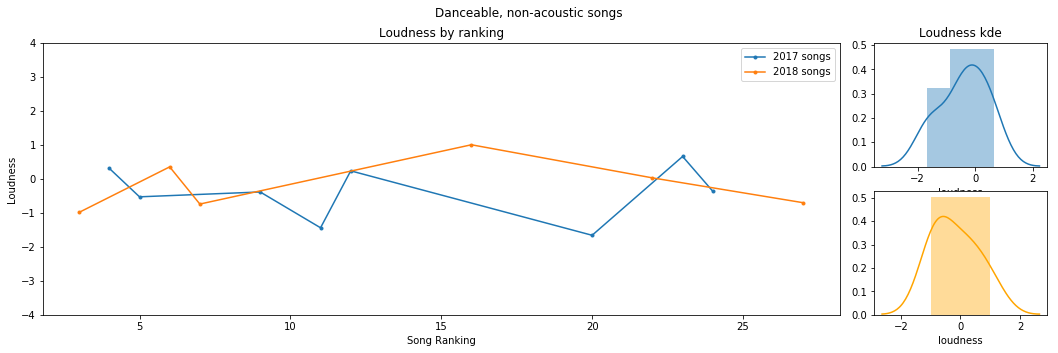

In [16]:
glob_non_ac = glob_non_ac[glob_non_ac['danceability'] > 0]
glob_non_ac_2018 = glob_non_ac_2018[glob_non_ac_2018['danceability'] > 0]
plot_loudness(glob_non_ac, glob_non_ac_2018, 'Danceable, non-acoustic songs')

Observations that are left after the filtering are quite homogenously distributed along the ordered top 30 observations. Kernel density estimates show that the expected value for the distribution has not significantly increased. This lets us conclude that our simple hypothesis about which features determine `loudness` didn't survive through simple exploration of the data. This suggests that it is difficult to understand the true complexity of the data, let alone make intuitive explanations about underlying true data generating process.

In our model, $\alpha$ determines the intercept point $x_0$ where $y=0$. However already this is difficult to have clear intuitions about in higher dimensions. We also have $\beta$-coefficients which together determine the slope of the line. As we saw in the previous sub-section, it is not trivial to develop well working intuitions about the way in which predictors affect the $Y$. As our domain knowledge is very restricted (compared to for example data analyst who have been working with this type of audio streaming data sets for years), we feel that in this particular case it is better to let the observed data drive the conclusions. 

In conclusion we will only use uninformative or weakly informative priors when defining the models.

## __3. Modeling and Inference__

In this notebook each model will go through following stages:
  * Stan model
  * Convergence diagnostics
  * Posterior predictive checking
  * Model evaluation

## __3.1 Three predictors linear model__    
For the first model we select only three of the predictor variables based on 1) feature importance based on random forest (pre-processing notebook) 2) collinearity (EDA-notebook) -- because of the assumptions of the linear model, we want to avoid highly collinear pairs such as `loudness ~ energy` and `valence` which is potentially collinear with many other covariates. Following predictors for this models are `danceability, acousticness` and `tempo`. 

Complete model takes the form: $ Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3, \;\sigma)$


We start the modeling with uninformative priors. This type of simple model gives us a crude picture of what the bayesian inference can tell us about the data, and it gives us a reference model which we can then compare the more complex models on.  
Here we let Stan take care of the priors, and it chooses __*uniform priors by default*__. This is also known as the *ordinary linear regression*:

### __Load model__

In [24]:
model_name = ['Model 1: 3 Predictors, Uninformative']
filename = 'lin_3_uninformative.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // tempo
    
    // year 2018 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred; 
}

parameters{
    real a;
    vector[3] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3;
}

model{
    y ~ normal(mu, sigma);
}

generated quantities{
    vector[Npred] ypred_2018;
    vector[N] ypred;
    vector[N] log_lik;
    
    for (j in 1:N){ 
        // logarithmic likelihood for streams (PSIS-LOO)
        log_lik[j] = normal_lpdf(y[j] | mu, sigma);
    }
    
    for (j in 1:Npred){
        // prediction for year 2018
        ypred_2018[j] = normal_rng(a + b[1]*X1pred[j] + b[2]*X2pred[j] + b[3]*X3pred[j], sigma);
        ypred[j] = normal_rng(a + b[1]*X1[j] + b[2]*X2[j] + b[3]*X3[j], sigma)

#### Setting up dataframe to accommodate model comparison

In [115]:
loos = pd.DataFrame(index=[], columns=["loo", "warning", "treedepth", "div"])

In [25]:
num_b = 3
gb_2017 = global_data.values
gb_2018 = global_data_2018.values 

data = dict(N=gb_2017.shape[0],
            y=gb_2017[:,0],
            X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,4], X4=gb_2017[:,5], X5=gb_2017[:,6],
            Npred=gb_2018.shape[0], 
            X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,3], X4pred=gb_2018[:,4], X5pred=gb_2018[:,5],
            mu_a=0,
            mu_b=np.zeros(num_b),
            sigma_0=0.12*10)

### __Fit model__

In [26]:
# Load compiled model if available
model = compile_model(filename, model_name=model_name) 
fit = model.sampling(data=data, seed=2222)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_79ac41797f92155d6fc6d02013b0af5b NOW.


In [118]:
samples = fit.extract(permuted=True) # Extract samples

### __Simulation results__ | Posterior

In [119]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:num_b+2,0:10]

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
a,8.774083,0.000293,0.018475,8.737628,8.762250,8.773631,8.786050,8.811840,3977.814460,0.999426
b[1],0.024649,0.000237,0.015494,-0.006393,0.014677,0.024506,0.035100,0.054683,4291.545842,0.999662
b[2],0.026977,0.000285,0.018368,-0.010112,0.014825,0.027040,0.039314,0.062038,4150.062894,0.999482
b[3],0.045904,0.000391,0.024032,-0.002407,0.030046,0.046332,0.061807,0.092253,3784.439618,0.999822
sigma,0.097116,0.000258,0.014488,0.073484,0.086797,0.095401,0.105654,0.130574,3163.271457,1.000832


$\hat R$ is below 1.1 which suggests convergence and $n_{eff}$ is close to the actual sample size (4000) which indicates that samples are not highly correlated. Sampling is effective.

Next we check __divergence, treedepth__ and __energy__:

In [120]:
div_check = pystan.diagnostics.check_div(fit, verbose = 2)

INFO:pystan:No divergent transitions found.


In [121]:
tree_check = pystan.diagnostics.check_treedepth(fit, verbose = 2)

INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit


In [27]:
energy_check = pystan.diagnostics.check_energy(fit, verbose = 2)

INFO:pystan:Chain 1: E-BFMI (= 0.941175959152892) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 1.012592226745531) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 0.9404914965286096) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 0.9821963799121658) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


In conclusion the convergence is successful.

### __Plot Trace and Kernel Density Estimates__ | Convergence Analysis

Text(0.5, 0.98, '')

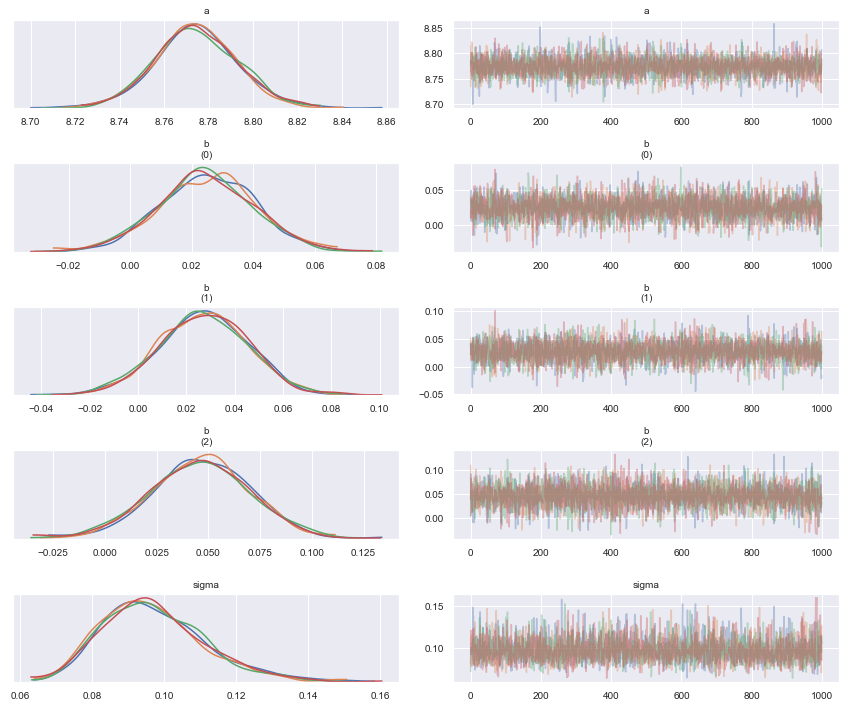

In [159]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior[['a','b','sigma']]

az.plot_trace(azpos)
plt.suptitle('')

### __Model check__ | Cross validation


In [167]:
p, loos = calculate_and_print_loo(fit,loos)
p

,loo,loo_se,p_loo,warning,div,treedepth,energy
Model,,,,,,,
"Model 1: 3 Predictors, Uninformative",330.12607,1193.251565,1216.707605,1,False,True,True


Cross validation is computed on log likelihood so negative values close to zero usually correspond with good fit. High positive score suggests that the model is overfitting. Also standard error is large indicating high variance and model is not reliable. In addition the warning column suggests that there at least one k shape parameter that is beyond the treshold value 0.7 so the LOO values are unreliable.

$p_{LOO}$ is the effective number of parameters and it's much bigger than the number of parameters specified in our model indicating that the model is inappropriate. In conclusion we can say that this model can't handle the true complexity of the data.   

### __Posterior Predictive Performance __

In [24]:
# Inversing log-transformation
linear_samples = samples
linear_samples['ypred'] = exp10_t(samples['ypred'])
linear_samples['ypred_2018'] = exp10_t(samples['ypred_2018'])

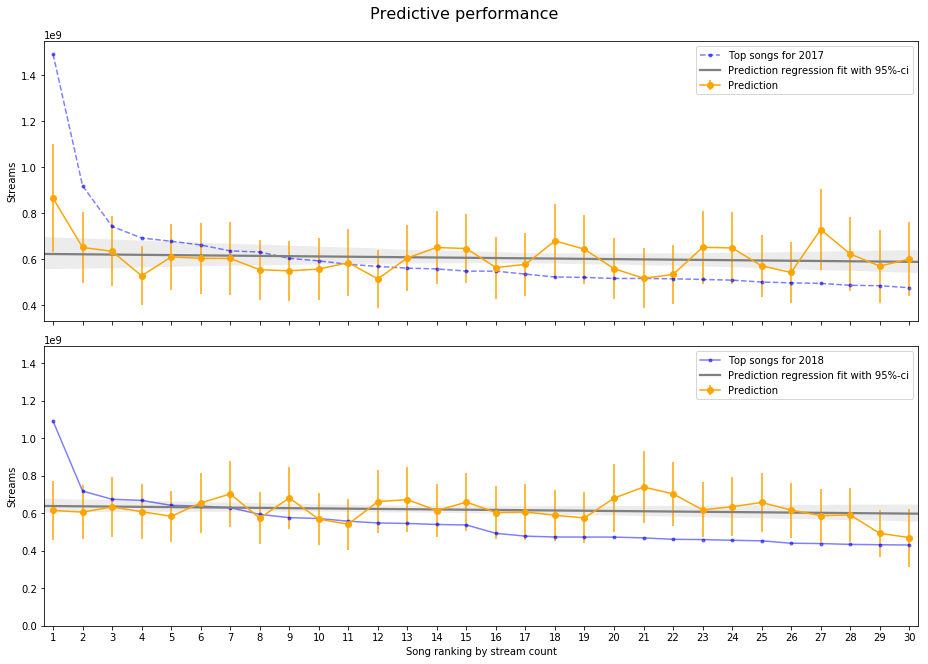

In [54]:
plot_predictive_acc(global_data, global_data_2018, linear_samples)

Upper plot shows the posterior predictive samples overlayed on top of the true values of target variable $Y$. Although there is a lot variation, the model manages to generalize to certain extent; namely we can see that in is able to predict the highest performing song correctly. It also tells us that the model has too much variance to be generally reliable as can be seen from the overall prediction performance.

Bottom plot shows the posterior predictive samples based on the 2018 song's feature variables. As can be seen the model trained using 2017 data doesn't generalize well for the new data. Therefore continue to explore more complicated models.

## __3.2 Five predictors__ | Non-linear model with interaction terms
One of the common priors for linear regression is Zellner's g-prior with independent Gaussian priors such that for each $j \mid 1 \leq j \leq d$ and $\beta_j \sim N(0, \frac{\sigma^2}{g})$ and often the unit information prior $g = 1 / n$ is used.

Now we assume independent prior distributions following Zellner's g-prior for $\alpha$ and $\beta_j$'s such that $\alpha \sim N(0, 100\sigma_0^2)$, and $\beta_j \sim N(0, 100\sigma_0^2)$.

Complete model takes the form: 
$ Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5 + \beta_6 X_2 X_4 + \beta_7 X_3 X_5 + \beta_8 X_1 X_5 + \beta_9 X_2 X_5, \;\sigma)$  



In the exploratory data analysis part of this analysis we identified multiple potential collinear relationships between covariates. We will now relax the linearity assumption of the model and introduce two new interaction terms. 

Interaction terms model:
1. potential positive collinearity between `valence` and `loudness`
2. negative collinearity between `tempo` and `danceability`.
3. potential positive collinearity between `valence` and `danceability`
4. potential positive collinearity between `valence` and `acousticness`.

### __Load model__

In [22]:
model_name = ['Model 2: 5 Predictors with 2 interaction terms']
filename = 'lin_5_informative-interaction2.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[9] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[9] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    vector[N] X2X4;
    vector[N] X1X5;
    vector[N] X2X5;
    vector[N] X3X5;
    
    X1X5 = X1 .* X5;
    X2X5 = X2 .* X5;
    X3X5 = X3 .* X5;
    X2X4 = X2 .* X4;
    
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3 + b[4]*X4 + b[5]*X5 + b[6]*X2X4 + b[7]*X3X5 + b[8]*X1X5 + b[9]*X2X5;
}

model{
    a ~ normal(mu_a, sigma_0);
    b ~ normal(mu_b, sigma_0

In [71]:
num_b = 9
gb_2017 = global_data.values
gb_2018 = global_data_2018.values 

data = dict(N=gb_2017.shape[0],
            y=gb_2017[:,0],
            X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,4], X4=gb_2017[:,5], X5=gb_2017[:,6],
            Npred=gb_2018.shape[0], 
            X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,3], X4pred=gb_2018[:,4], X5pred=gb_2018[:,5],
            mu_a=0,
            mu_b=np.zeros(num_b),
            sigma_0=0.12*10)

### __Fit model__

In [ ]:
# Load compiled model if available
model = compile_model(filename, model_name=model_name) 
fit = model.sampling(data=data, seed=2222)

In [73]:
samples = fit.extract(permuted=True) # Extract samples

### __Simulation results__ | Posterior

In [74]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:num_b+2,0:10]

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
a,8.728424,0.000389,0.020158,8.688706,8.715223,8.728735,8.741788,8.767825,2686.726787,1.002356
b[1],0.003220,0.000322,0.016158,-0.028904,-0.007326,0.003327,0.013890,0.034465,2511.786295,1.001377
b[2],-0.002634,0.000388,0.019684,-0.041825,-0.015390,-0.002223,0.010088,0.035605,2572.578450,1.001855
b[3],0.023101,0.000529,0.027000,-0.030475,0.005858,0.022815,0.040605,0.076748,2605.178369,1.000530
b[4],0.027016,0.000383,0.019940,-0.013155,0.014176,0.027138,0.039676,0.065983,2711.904930,1.000195
b[5],0.029483,0.000419,0.020094,-0.009965,0.016512,0.029381,0.042268,0.069783,2296.859189,1.000317
b[6],0.007542,0.000239,0.012875,-0.018944,-0.000806,0.007785,0.016088,0.031846,2912.674506,0.999619
b[7],0.041150,0.000444,0.021241,-0.001396,0.027209,0.041060,0.054908,0.083597,2293.681479,1.001113
b[8],0.036689,0.000350,0.017272,0.002548,0.025334,0.036436,0.048419,0.069716,2439.766179,1.001106
b[9],0.016165,0.000450,0.021787,-0.026057,0.001301,0.016381,0.030376,0.059523,2345.333936,1.000470


Once again $\hat R$ is below 1.1 and now the $n_{eff}$ is close to half of the actual sample size for all of the parameters suggesting that convergence is fine but samples are more correlated than in the previous model. This is to be expected with the addition of interaction terms and the relaxing of linearity assumptions.

Next we check __divergence, treedepth__ and __energy__:

In [75]:
div_check = pystan.diagnostics.check_div(fit, verbose = 2)

INFO:pystan:No divergent transitions found.


In [76]:
tree_check = pystan.diagnostics.check_treedepth(fit, verbose = 2)

INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit


In [77]:
energy_check = pystan.diagnostics.check_energy(fit, verbose = 2)

INFO:pystan:Chain 1: E-BFMI (= 0.763296018790109) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 0.9167053101127984) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 0.8184331019442744) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 0.841979101240947) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


The convergence diagnostics are all fine.

### __Plot Trace and Kernel Density Estimates__ | Convergence Analysis

Text(0.5, 0.98, '')

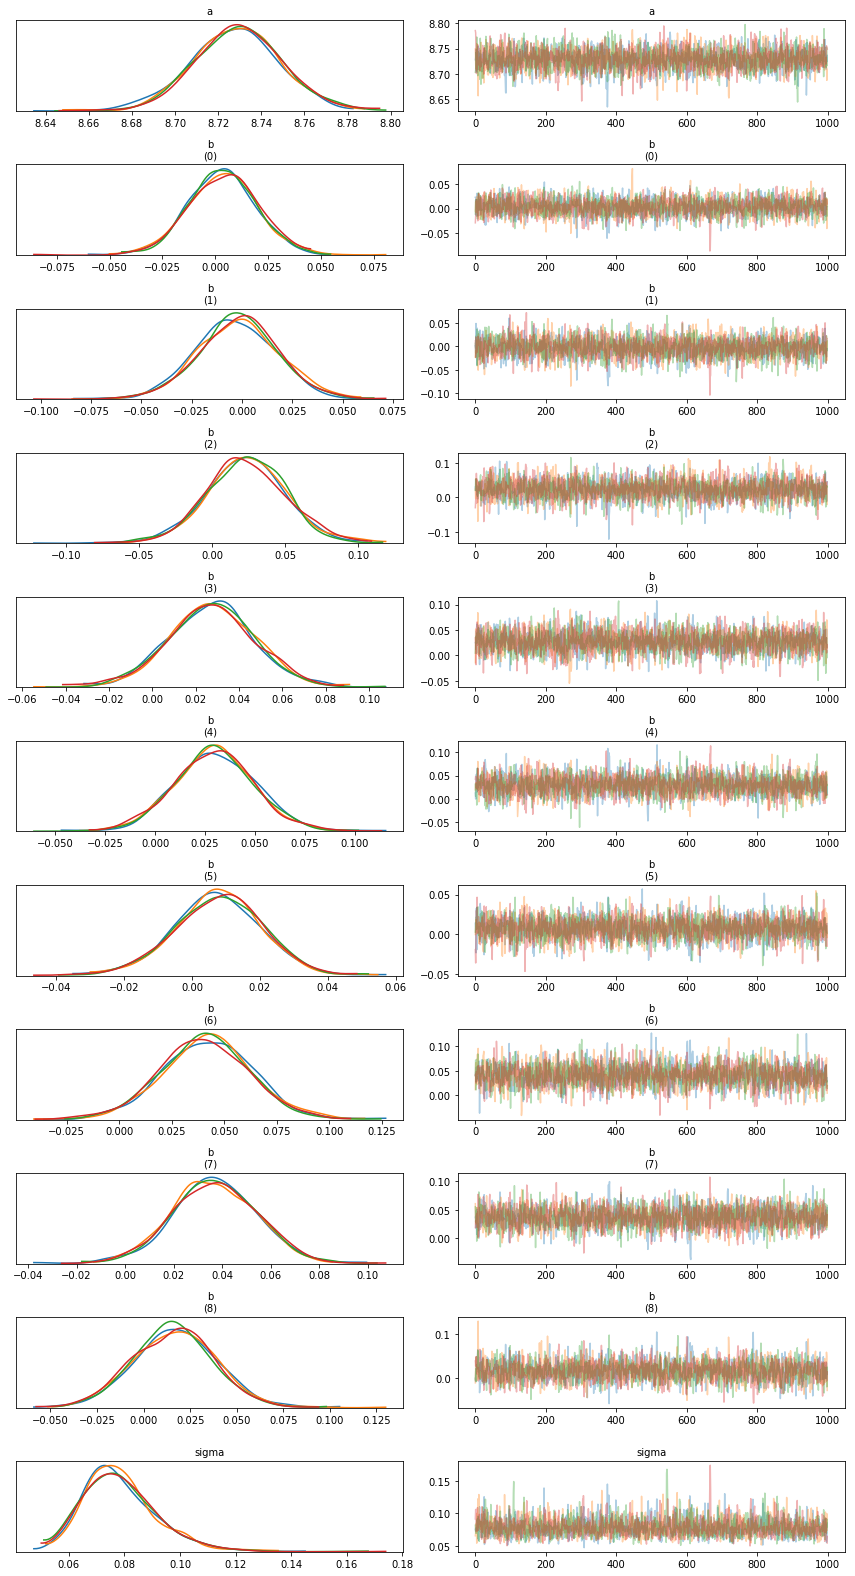

In [78]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior[['a','b','sigma']]

az.plot_trace(azpos)
plt.suptitle('')

### __Model check__ | Cross validation


In [79]:
p, loos = calculate_and_print_loo(fit,loos)
p

,loo,loo_se,p_loo,warning,div,treedepth,energy
Model,,,,,,,
Model 2: 5 Predictors with 2 interaction terms,3072.952117,1970.499454,2411.396402,1,True,True,True


Large LOO and LOO standard error values suggests that the model is overfitting significantly. $p_{LOO}$ values are twice the previous model's which indicates that . In conclusion we can say that this model can't handle the true complexity of the data. Here again warning exists indicating that at least one of the estimated shape parameters for the Pareto distribution is greater than 0.7. Thus the LOO values are unreliable.

### __Posterior Predictive Performance __

In [84]:
# Inversing log-transformation
linear_samples = samples
linear_samples['ypred'] = exp10_t(samples['ypred'])
linear_samples['ypred_2018'] = exp10_t(samples['ypred_2018'])

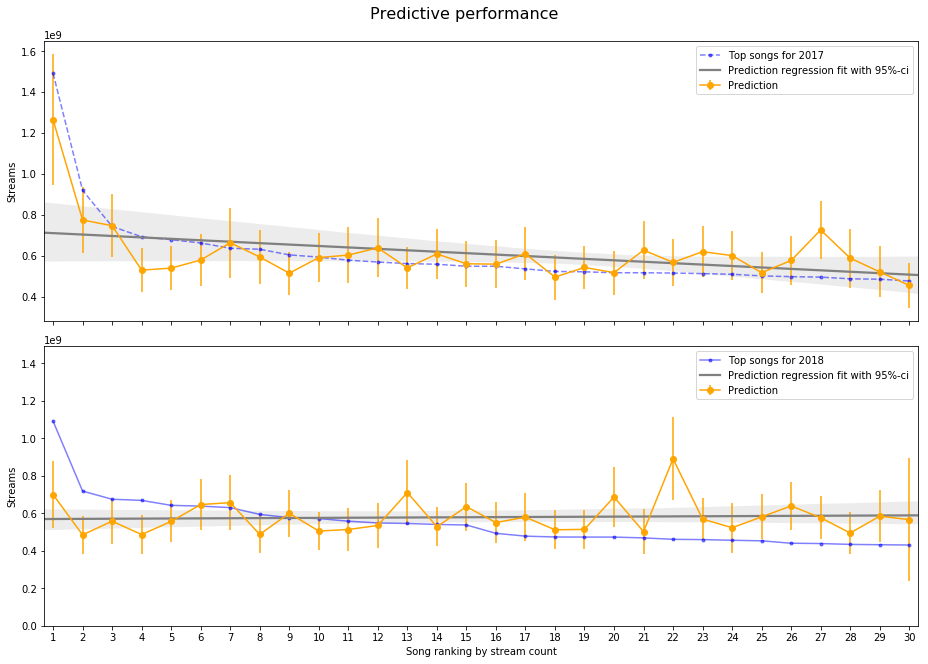

In [85]:
plot_predictive_acc(global_data, global_data_2018, linear_samples)

The predictive performance of the model for the 2017 data is significantly improved, although there are still large variations between posterior samples.

For 2018 data the model still doesn't seem to generalize well. 
It's becoming obvious from the model diagnostics that our model is not robust enough. The disparity between 2017 and 2018 predictive performance could also suggest that the top 30 for 2018 is driven by different trends compared to 2017. 

## __4. Model Comparison__
Due to poor performance of the simple models we explored more complicated models. We ended up constructing eight regression models in total which can be explored in more detail in our [github repository](). Basic convergence diagnostics and LOO scores are presented in the table below. 

In [21]:
loos = pd.read_csv('./model_comparison.csv')
loos.set_index('Model')

,div,energy,loo,loo_se,p_loo,treedepth,warning
Model,,,,,,,
Linear; 3 Predictors Uninformative,False,True,330.126070,1193.251565,1216.707605,True,1
"Linear; 3 Predictors Weakly Informative, Normal",True,True,414.275619,1201.617354,1270.207832,True,1
"Linear; 5 Predictors Weakly Informative, Normal",True,True,568.040652,1219.729017,1318.150582,True,1
"Non-Linear; 5 Predictors Weakly Informative inter 1, Normal",True,True,1692.046913,1611.779674,1805.222313,True,1
"Non-Linear; 5 Predictors Weakly Informative inter 2, Normal",True,True,3072.952117,1970.499454,2411.396402,True,1
"Non-Linear; 5 Predictors Weakly Informative squared, Normal",True,True,2255.697280,1633.004880,2001.678876,True,1
"Non-Linear; 5 Predictors Weakly Informative squared inter, Normal",True,True,3231.741395,1890.545766,2446.777666,True,1
"Non-Linear; 5 Predictors Weakly Informative cubic, Normal",True,True,7528.847211,3188.444969,4436.048235,True,1


We can see from the model comparison diagnostics that the as the models complexity increases models tend to overfit and LOO standard error together with effective number of parameters increases significantly. Even the models with best LOO scores are not reliable. This is indicated by the fact that at least one of the estimated shape parameters for the Pareto distribution is greater than 0.7 (warning = 1) for all of the models. Thus the effective comparison is difficult and LOO values are generally unreliable. 

Based on the LOO scores we would select the simplest model with three predictors and uninformative priors. However we would emphasize that none of the models is performing well and in order to be successful it would be necessary to find ways to construct better models.

## __5. Conclusion__
We found that the audio features lack explanatory power to predict Spotify top song rankings. Due to high variance in the data, our models are not robust nor reliable. As we increase model complexity, the model's capability to generalize decreases. 

More limitations and suggested improvements are discussed in the next section. 

## __6. Limitations and future improvements__
There are inherent limitations in our data set; the data that we were provided with does not seem to contain sufficient information to effectively predict the song rankings on Spotify. The data set has very high variation which further inhibits our models predictive capability. In the end we conclude that the regression models used are not able to generalize well on new data. The model diagnostics indicate that although the HMC simulation converges, the PSIS-LOO measurements shows a combination of high standard error and high $p_{LOO}$ values suggesting that even our simplest models are overfitting significantly.  



Predictive performance could be improved by gathering data that contains more relevant information about the true data generating process. Example of this could be information about marketing compaigns or social media mentions; the artists and genre could also be good predictors. Moreover some of the complexity could be tackled by taking advantage of domain expertise in developing more informative priors. Due to the time series nature of the problem, appropriate hierarchical models could be constructed in a way which allows models to update themselves based on the latest data.